In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from datetime import datetime
from dateutil.relativedelta import relativedelta

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL




In [ ]:
predict = 42
period = 252

In [ ]:
# Get the current date
today = datetime.today()
day_ago = today
final_date = day_ago.strftime("%Y-%m-%d")
final_date

'2024-08-05'

In [ ]:
# Step 1: Data Collection
ticker = "^GSPC"
data = yf.download(ticker, start="1990-09-15", end=final_date)
data = data.reset_index()
df = data[['Date', 'Close']]


[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Apply log transformation
df.loc[:, 'Close'] = np.log(df['Close'])


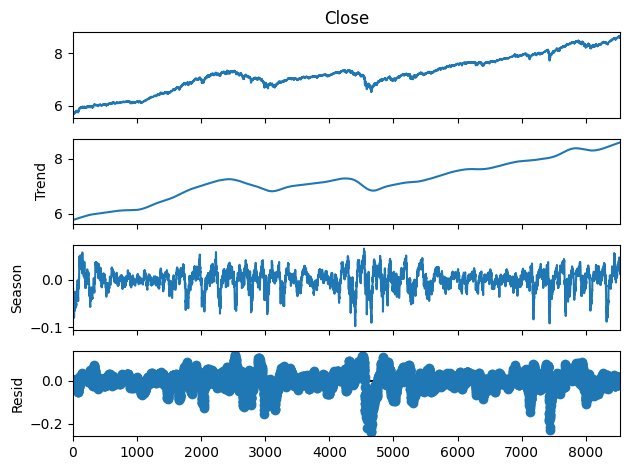

In [ ]:
stl = STL(df['Close'], period=252)  # Seasonal period for daily data (1 year)
result = stl.fit()
trend = result.trend
seasonal = result.seasonal
residual = result.resid
result.plot()
plt.show()


In [ ]:
data = pd.DataFrame({
    'Seasonal': seasonal,
    'Residual': residual
})

In [ ]:
data['Variance'] = data['Seasonal'] + data['Residual']

In [ ]:
msk = (trend.index < len(trend)-predict)
trend_train = df[msk].copy()
trend_test = df[~msk].copy()

In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.6 MB/s eta 0:00:00


In [ ]:
import pmdarima as pm
auto_arima = pm.auto_arima(trend_train['Close'], stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(0, 1, 5), scoring_args={}, suppress_warnings=True)

In [ ]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3219
Model:               SARIMAX(3, 1, 2)   Log Likelihood               10060.065
Date:                Sat, 03 Aug 2024   AIC                         -20106.129
Time:                        14:19:46   BIC                         -20063.594
Sample:                             0   HQIC                        -20090.884
                               - 3219                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.000      1.862      0.063   -1.62e-05       0.001
ar.L1         -0.4365      0.107     -4.095      0.000      -0.645      -0.228
ar.L2          0.4780      0.108      4.415      0.000       0.266       0.690
ar.L3          0.1361      0.015      9.266      0.000       0.107       0.165
ma.L1          0.3141      0.109      2.886      0.004       0.101       0.528
ma.L2         -0.5165      0.101     -5.128      0.000      -0.714      -0.319
sigma2         0.0001   1.33e-06     83.397      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   2.00   Jarque-Bera (JB):             15616.10
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               1.56   Skew:                            -0.77
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Forecasting for the next 30 days
forecast_test_auto = auto_arima.predict(n_periods=len(trend_test))

NameError: name 'auto_arima' is not defined

In [ ]:
# Creating the forecast column
df['Trend'] = np.nan
df.loc[df.index[-predict:], 'Trend'] = forecast_test_auto

In [ ]:
# Filter the last 252 days for plotting
df_last_period = df.iloc[-period:].copy()

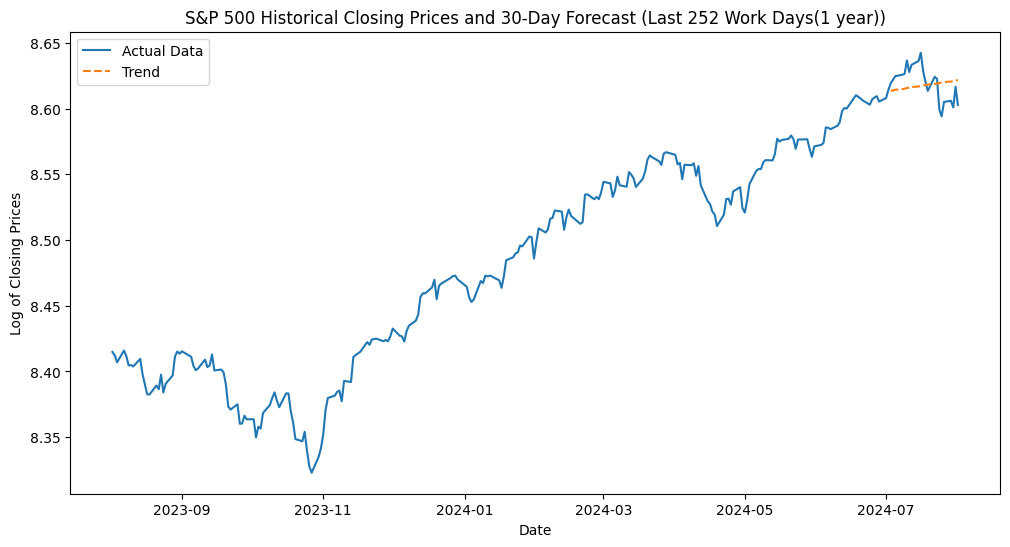

In [ ]:
# Plotting the actual and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(df_last_period['Date'], df_last_period['Close'], label='Actual Data')
plt.plot(df_last_period['Date'], df_last_period['Trend'], label='Trend', linestyle='--')
plt.title('S&P 500 Historical Closing Prices and 30-Day Forecast (Last 252 Work Days(1 year))')
plt.xlabel('Date')
plt.ylabel('Log of Closing Prices')
plt.legend()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow import keras
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
dataset = min_max_scaler.fit_transform(data['Variance'].values.reshape(-1, 1))

In [ ]:
test_size = predict + 2
train_size = len(dataset) - test_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=predict):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
x_train, y_train = create_dataset(train)
x_test, y_test = create_dataset(test)

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

In [ ]:
model = Sequential()
model.add(LSTM(units=30, activation='relu', return_sequences=True, input_shape=(1, predict)))
model.add(LSTM(units=40, activation='relu', return_sequences=True))
model.add(LSTM(units=50, activation='relu', return_sequences=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=3, batch_size=1, verbose=2)

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3195/3195 - 13s - 4ms/step - loss: 0.0115
Epoch 2/3
3195/3195 - 10s - 3ms/step - loss: 0.0016
Epoch 3/3
3195/3195 - 9s - 3ms/step - loss: 0.0014


In [ ]:
 #Get the last 21 entries from the dataset
last_21 = dataset[-predict:]
forecast = []

# Reshape the last 21 entries to fit the model input shape
prediction = last_21.reshape(1, 1, predict)  # Reshape to (1, 1, predict)

for _ in range(predict):
    temp = model.predict(prediction)  # Predict the next value
    forecast.append(temp[0, 0, -1])  # Append the predicted value to the forecast list

    # Update the prediction window by shifting left and adding the new prediction
    prediction = np.append(prediction[:, :, 1:], temp[0, 0, -1].reshape(1, 1, 1), axis=2)  # Maintain shape (1, 1, predict)

# Convert forecast list to a numpy array for scaling
forecast = np.array(forecast).reshape(-1, 1)

# Inverse transform the forecast to get the original scale values
forecast = min_max_scaler.inverse_transform(forecast)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [ ]:
forecast

array([[ 0.00433803],
       [-0.00030452],
       [-0.00418969],
       [-0.00718432],
       [-0.01103175],
       [-0.01517134],
       [-0.01946548],
       [-0.02295613],
       [-0.02462664],
       [-0.02655204],
       [-0.02950525],
       [-0.0327675 ],
       [-0.03461448],
       [-0.0357654 ],
       [-0.03797659],
       [-0.03915242],
       [-0.04098311],
       [-0.04219881],
       [-0.04383206],
       [-0.04431243],
       [-0.04482618]], dtype=float32)

In [ ]:
# Creating the forecast column
df['Variance'] = np.nan
df.loc[df.index[-predict:], 'Variance'] = forecast
df['Forecast'] = df['Variance'] + df['Trend']
# Filter the last 252 days for plotting
df_last_period = df.iloc[-period:].copy()

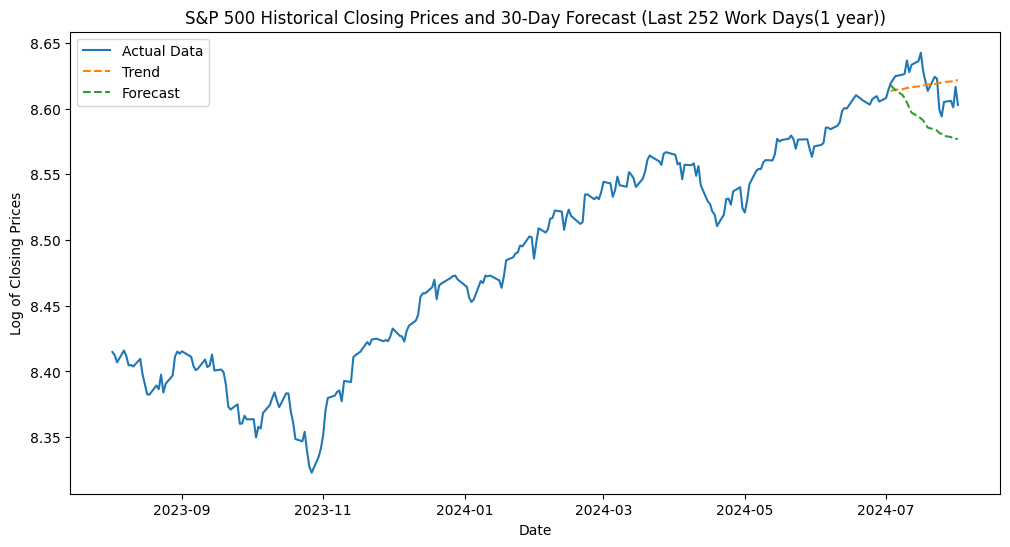

In [ ]:
# Plotting the actual and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(df_last_period['Date'], df_last_period['Close'], label='Actual Data')
plt.plot(df_last_period['Date'], df_last_period['Trend'], label='Trend', linestyle='--')
plt.plot(df_last_period['Date'], df_last_period['Forecast'], label='Forecast', linestyle='--')
plt.title('S&P 500 Historical Closing Prices and 30-Day Forecast (Last 252 Work Days(1 year))')
plt.xlabel('Date')
plt.ylabel('Log of Closing Prices')
plt.legend()
plt.show()

In [ ]:
# Invert the logarithm
df.loc[:, 'Close'] = np.exp(df['Close'])
# Invert the logarithm
df.loc[:, 'Trend'] = np.exp(df['Trend'])
# Invert the logarithm
df.loc[:, 'Forecast'] = np.exp(df['Forecast'])

In [ ]:
df_last_period = df.iloc[-period:].copy()

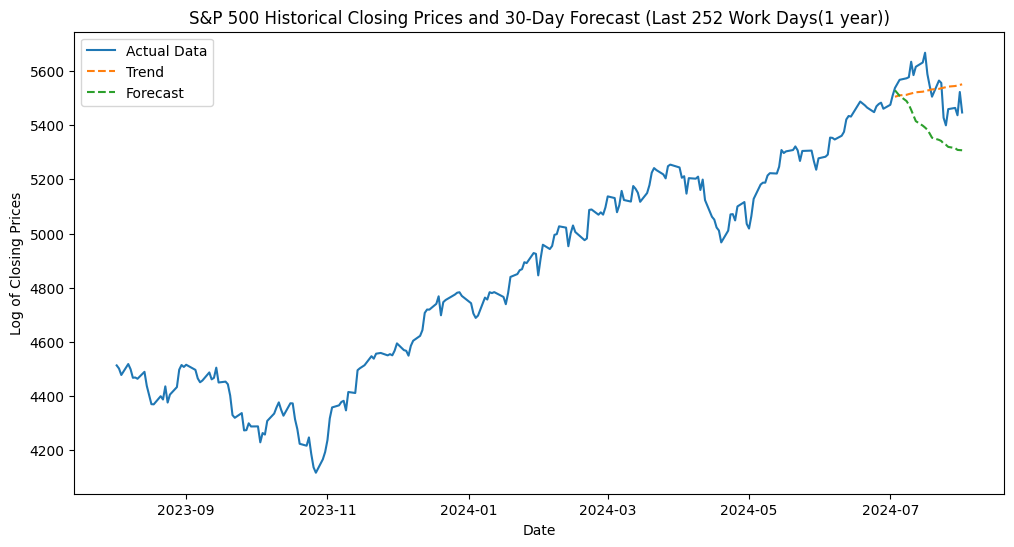

In [ ]:
# Plotting the actual and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(df_last_period['Date'], df_last_period['Close'], label='Actual Data')
plt.plot(df_last_period['Date'], df_last_period['Trend'], label='Trend', linestyle='--')
plt.plot(df_last_period['Date'], df_last_period['Forecast'], label='Forecast', linestyle='--')
plt.title('S&P 500 Historical Closing Prices and 30-Day Forecast (Last 252 Work Days(1 year))')
plt.xlabel('Date')
plt.ylabel('Log of Closing Prices')
plt.legend()
plt.show()

In [ ]:
model.save('my_model.keras')